# Airline

In [1]:
%load_ext watermark
%watermark  -d -u -a 'Sebastian Raschka' -v -p numpy,scipy,matplotlib,sklearn

Author: Sebastian Raschka

Last updated: 2021-11-30

Python implementation: CPython
Python version       : 3.7.1
IPython version      : 7.2.0

numpy     : 1.21.2
scipy     : 1.7.1
matplotlib: 3.0.2
sklearn   : 1.0



In [142]:
from sklearn.metrics import confusion_matrix
import numpy as np


import pandas as pd
from pandas import DataFrame
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

# Going to use these 5 base models for the stacking
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC

<div class="paragraph">
  <p><br></p>
  <p><br></p>
  <p><br></p>
  <p><br></p>
  <p><br></p>
  <p><br></p>
</div>

# 1. Hyperparameter Tuning and Model Selection

In this exercise, you will be working with a diabetes dataset which is available from OpenML (https://www.openml.org/d/37).


The dataset contains information about 768 patients along with the Diabetes diagnosis. The Diabetes diagnosis is a binary label, where "tested_positive" means that a patient has diabetes and "tested_negative" means that a patient does not have diabetes.

I additional to the class label, there are 8 numeric features in the dataset, which are listed below:

1. Number of times pregnant 
2. Plasma glucose concentration a 2 hours in an oral glucose tolerance test 
3. Diastolic blood pressure (mm Hg) 
4. Triceps skin fold thickness (mm) 
5. 2-Hour serum insulin (mu U/ml) 
6. Body mass index (weight in kg/(height in m)^2) 
7. Diabetes pedigree function 
8. Age (years)


## 1.1  Using Grid Search for Hyperparameter Tuning

### 1.1.1) Load the Dataset [5 Pts]

Use pandas to load the dataset from the `dataset_37_diabetes` file from OpenML. (Hint: I provided the correct link for that, but you need to change something in the `read_csv` default code to load it correctly.)

In [2]:
import numpy as np
import pandas as pd

/Users/hazelma/anaconda3/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.8' currently installed).
  warnings.warn(msg, UserWarning)


In [175]:
import pandas as pd


df = pd.read_csv('air.na.omit.csv') 
df.head()

,Unnamed: 0,X,id,Gender,Customer.Type,Age,Type.of.Travel,Class,Flight.Distance,Inflight.wifi.service,...,Inflight.entertainment,On.board.service,Leg.room.service,Baggage.handling,Checkin.service,Inflight.service,Cleanliness,Departure.Delay.in.Minutes,Arrival.Delay.in.Minutes,satisfaction
0,1,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,...,5,4,3,4,4,5,5,25,18,neutral or dissatisfied
1,2,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,...,1,1,5,3,1,4,1,1,6,neutral or dissatisfied
2,3,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,...,5,4,3,4,4,4,5,0,0,satisfied
3,4,3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,...,2,2,5,3,1,4,2,11,9,neutral or dissatisfied
4,5,4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,...,3,3,4,4,3,3,3,0,0,satisfied


### 1.1.2) Preprocess the class label [5 Pts]

Convert the class label using pandas `apply` or `map` method. The mapping should be as follows:

- `'tested_positive'` should be converted to `1`
- `'tested_negative'` should be converted to `0`

In [173]:
df['satisfaction'] = df['satisfaction'].map( lambda x: 1 if x == 'satisfied' else (0 if x == "neutral or dissatisfied" else None) )
df['Gender'] = df['Gender'].map( lambda x: 1 if x == 'Male' else (0 if x == "Female" else None) )
df['Customer.Type'] = df['Customer.Type'].map( lambda x: 1 if x == 'Loyal Customer' else (0 if x == "disloyal Customer" else None) )
df['Type.of.Travel'] = df['Type.of.Travel'].map( lambda x: 1 if x == 'Business travel' else (0 if x == "Personal Travel" else None) )
df['Class'] = df['Class'].map( lambda x: 2 if x == 'Business' else (1 if x == "Eco Plus" else (0 if x == "Eco" else None) ))
df.head()

,Gender,Customer.Type,Age,Type.of.Travel,Class,Departure.Delay.in.Minutes,Arrival.Delay.in.Minutes,satisfaction
0,None,None,13,None,None,25,18,None
1,None,None,25,None,None,1,6,None
2,None,None,26,None,None,0,0,None
3,None,None,25,None,None,11,9,None
4,None,None,61,None,None,0,0,None


In [154]:
df.isnull().any()

Unnamed: 0                           False
X                                    False
id                                   False
Gender                               False
Customer.Type                        False
Age                                  False
Type.of.Travel                       False
Class                                False
Flight.Distance                      False
Inflight.wifi.service                False
Departure.Arrival.time.convenient    False
Ease.of.Online.booking               False
Gate.location                        False
Food.and.drink                       False
Online.boarding                      False
Seat.comfort                         False
Inflight.entertainment               False
On.board.service                     False
Leg.room.service                     False
Baggage.handling                     False
Checkin.service                      False
Inflight.service                     False
Cleanliness                          False
Departure.D

### 1.1.3) Split dataset into training and test sets [5 Pts]

- Split the dataset into 70% training and 30% test data
- Perform a stratified split
- use `0` as the random seed for shuffling

In [187]:
from sklearn.model_selection import train_test_split


y = df['satisfaction'].values
X = df.iloc[:, :-1].values

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, train_size=0.7,test_size=0.3, random_state=0,stratify=y)

# StandardScaler

In [188]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# try stacking

## baseline

In [189]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from mlxtend.classifier import StackingCVClassifier
from sklearn.linear_model import LogisticRegression


forest = RandomForestClassifier(n_estimators=100,
                                random_state=123)

boost = XGBClassifier(random_state=123, verbosity=0, use_label_encoder=False)

metaclassifier = LogisticRegression(random_state=123)

sclf = StackingCVClassifier(classifiers=[forest, boost], 
                            meta_classifier=metaclassifier, 
                            random_state=123)

Random forest

In [190]:
forest.fit(X_train, y_train)
print(f"Training Accuracy: {forest.score(X_train, y_train):0.4f}")
print(f"Test Accuracy: {forest.score(X_test, y_test):0.4f}")

Training Accuracy: 0.9962
Test Accuracy: 0.9440


Gradient boosting:

In [191]:
boost.fit(X_train, y_train)
print(f"Training Accuracy: {boost.score(X_train, y_train):0.4f}")
print(f"Test Accuracy: {boost.score(X_test, y_test):0.4f}")

Training Accuracy: 0.9127
Test Accuracy: 0.9118


Stacking:

In [192]:
sclf.fit(X_train, y_train)
print(f"Training Accuracy: {sclf.score(X_train, y_train):0.4f}")
print(f"Test Accuracy: {sclf.score(X_test, y_test):0.4f}")

Training Accuracy: 0.9962
Test Accuracy: 0.9440


# Randomized Search

In [ ]:
import numpy as np
import scipy.stats
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline


pipe = make_pipeline(sclf)

params = {
    'stackingcvclassifier__use_probas': [True],
    'stackingcvclassifier__drop_proba_col': [None, 'last'],
    'stackingcvclassifier__xgbclassifier__reg_alpha': scipy.stats.loguniform(1e-5, 1),
    'stackingcvclassifier__xgbclassifier__max_depth': [2, 5, 8],
    'stackingcvclassifier__randomforestclassifier__n_estimators': [10, 100]
}


search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=params,
    n_iter=50,
    cv=5,
    verbose=2,
    n_jobs=1)

search.fit(X_train, y_train)
search.best_score_

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END stackingcvclassifier__drop_proba_col=last, stackingcvclassifier__randomforestclassifier__n_estimators=100, stackingcvclassifier__use_probas=True, stackingcvclassifier__xgbclassifier__max_depth=8, stackingcvclassifier__xgbclassifier__reg_alpha=1.3443702479505458e-05; total time=  39.8s
[CV] END stackingcvclassifier__drop_proba_col=last, stackingcvclassifier__randomforestclassifier__n_estimators=100, stackingcvclassifier__use_probas=True, stackingcvclassifier__xgbclassifier__max_depth=8, stackingcvclassifier__xgbclassifier__reg_alpha=1.3443702479505458e-05; total time=  40.0s
[CV] END stackingcvclassifier__drop_proba_col=last, stackingcvclassifier__randomforestclassifier__n_estimators=100, stackingcvclassifier__use_probas=True, stackingcvclassifier__xgbclassifier__max_depth=8, stackingcvclassifier__xgbclassifier__reg_alpha=1.3443702479505458e-05; total time=  39.7s
[CV] END stackingcvclassifier__drop_proba_col=last, s

In [184]:
print(f"Training Accuracy: {search.best_estimator_.score(X_train, y_train):0.4f}")
print(f"Test Accuracy: {search.best_estimator_.score(X_test, y_test):0.4f}")

Training Accuracy: 0.8044
Test Accuracy: 0.8037


In [166]:
best_estimator = search.best_estimator_

In [167]:
best_estimator

Pipeline(steps=[('stackingcvclassifier',
                 StackingCVClassifier(classifiers=[RandomForestClassifier(random_state=123),
                                                   XGBClassifier(max_depth=8,
                                                                 random_state=123,
                                                                 reg_alpha=5.769958826015241e-05,
                                                                 use_label_encoder=False,
                                                                 verbosity=0)],
                                      drop_proba_col='last',
                                      meta_classifier=LogisticRegression(random_state=123),
                                      random_state=123, use_probas=True))])

# corr

In [53]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import palettable

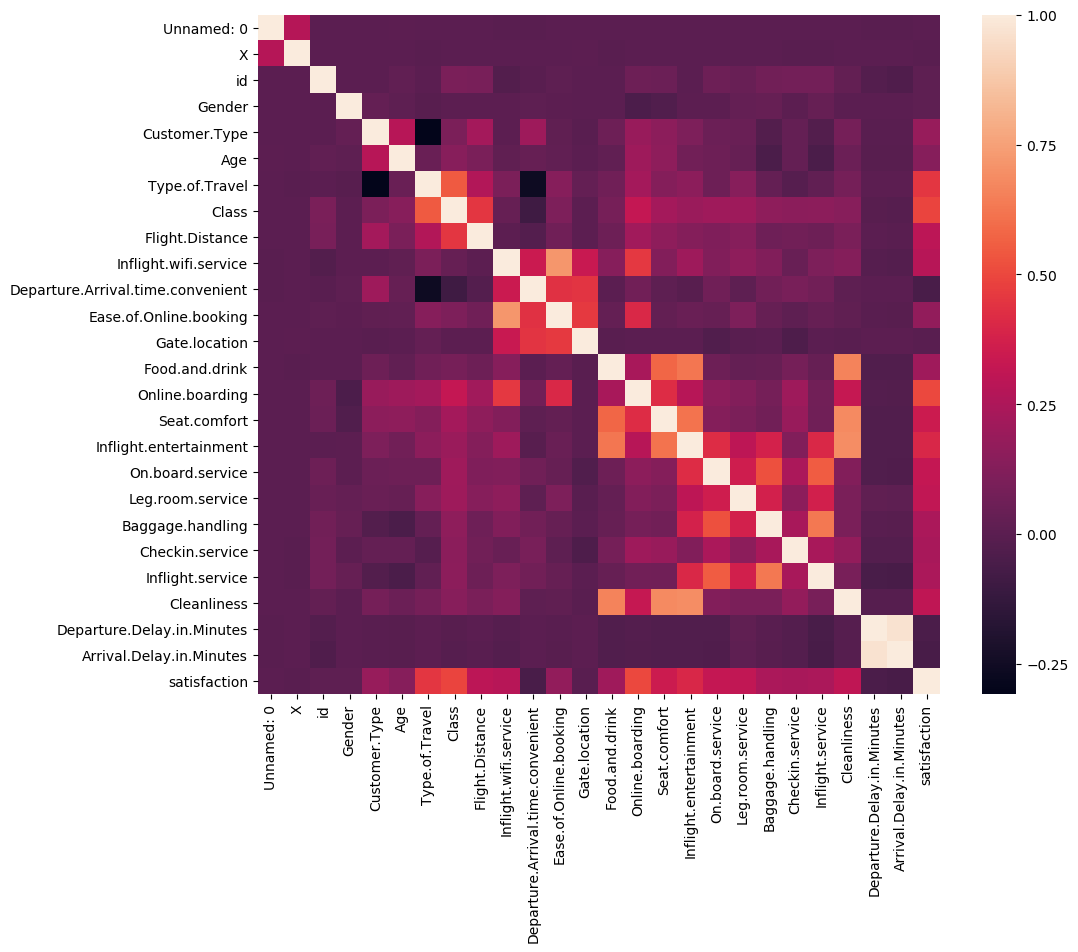

In [60]:
dcorr = df.corr(method='pearson')
plt.figure(figsize=(11, 9),dpi=100)
sns.heatmap(data=dcorr,
           )

fig = plt.gcf()
fig.savefig('corr.png', dpi=100)

NameError: name 'rf' is not defined

# LogisticRegression

In [63]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

LogisticRegression()

In [70]:
y_pred = classifier.predict(X_test)

## confusion matrix

In [72]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[19873,  2095],
       [ 2768, 14111]])

Text(30.5, 0.5, 'true')

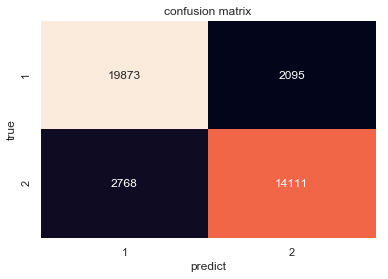

In [90]:
sns.set()
f,ax=plt.subplots()
sns.heatmap(cm,fmt='g',annot=True,cbar=False,xticklabels=xtick, yticklabels=ytick) #画热力图

ax.set_title('confusion matrix') #标题
ax.set_xlabel('predict') #x轴
ax.set_ylabel('true') #y轴

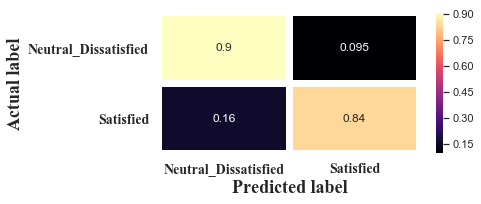

In [121]:
trans_mat = cm
   
trans_prob_mat = (trans_mat.T/np.sum(trans_mat, 1)).T


if True:
    label = ["Neutral_Dissatisfied",'Satisfied']
    df = pd.DataFrame(trans_prob_mat, index=label, columns=label)

    
    # Plot
    plt.figure(figsize=(7, 3))
    ax = sns.heatmap(df, xticklabels=df.corr().columns, 
                     yticklabels=df.corr().columns, cmap='magma',
                     linewidths=6, annot=True)
    
    # Decorations
    plt.xticks(fontsize=14,family='Times New Roman')
    plt.yticks(fontsize=14,family='Times New Roman')
    plt.ylabel('Actual label',fontsize=18,family='Times New Roman')
    plt.xlabel('Predicted label',fontsize=18,family='Times New Roman')
    
    plt.tight_layout()
    plt.savefig('./method_3.png', transparent=True, dpi=800)   
    plt.show()

## ROC

<Figure size 432x288 with 0 Axes>

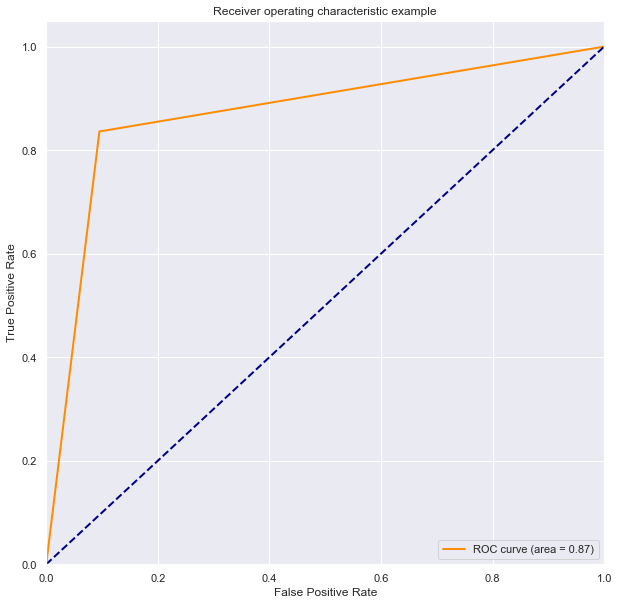

In [124]:


# Compute ROC curve and ROC area for each class
fpr,tpr,threshold = roc_curve(y_test, y_pred) ###计算真正率和假正率
roc_auc = auc(fpr,tpr) ###计算auc的值
 
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###假正率为横坐标，真正率为纵坐标做曲线
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.savefig('./roc', transparent=True, dpi=800)   
plt.show()

### 1.1.4) Gridsearch and model selection [5 Pts]

Now, your task is to use `GridSearchCV` from scikit-learn to find the best parameters for `max_depth` and `criterion` for a decision tree. For max_depth, the values `[1, 2, 3, 4, 5, 10, 15, 20, None]` should be tried, and for criterion both Gini and Entropy should be considered.

In [171]:
#------------------#
##### STUDENTS #####
#------------------#


from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV


tree = DecisionTreeClassifier(random_state=123)

param_grid = {'max_depth':[1, 2, 3, 4, 5, 10, 15, 20, None], 'criterion': ['gini', 'entropy'] }

gs = GridSearchCV(estimator=tree,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=10)

gs.fit(X_train, y_train)

print('Best Accuracy: %.2f%%' % (gs.best_score_*100))

Best Accuracy: 95.14%


Next, print the best hyperparameters obtained from the `GridSearchCV` run. Also, compute the accuracy the model, which uses the best hyperparameter settings and was trained on the whole training set, on the test set (`X_test`, `y_test`).

In [32]:
#------------------#
##### STUDENTS #####
#------------------#


print('Best Params: %s' % gs.best_params_)

## model is already fit to the whole training set because  we used `refit=True` in GridSearchCV
print('Test Accuracy: %.2f%%' % (gs.best_estimator_.score(X_test, y_test)*100))

Best Params: {'criterion': 'entropy', 'max_depth': 15}
Test Accuracy: 95.45%


In this exercise, you are asked to compute the accuracy of the model from the previous exercise (1.1), using the train set (`X_train`, `y_train`), via different bootstrap methods. 





### 1.2.1 Compare the Out-of-Bag, .632, and .632+ bootstrap approaches [5 pts]

For computing the bootstrap estimates and confidence intervals, you are going to use the `bootstrap_point632_score` function implemented in MLxtend: 
http://rasbt.github.io/mlxtend/user_guide/evaluate/bootstrap_point632_score/

The accruacy should be the mean accuracy over the 200 bootstrap values that the `bootstrap_point632_score` method returns.

- For this, use the best model you obtained from the previous exercise 1.1.4)
- use 200 bootstrap rounds
- set the random seed to 1

**Compute Out-of-bag Bootstrap:**

In [170]:
#------------------#
##### STUDENTS #####
#------------------#

from mlxtend.evaluate import bootstrap_point632_score
import numpy as np

# Compute Out-of-bag Bootstrap
scores = bootstrap_point632_score(gs.best_estimator_,
                                  X_train, y_train,
                                  n_splits=200, 
                                  method='oob',
                                  random_seed=1)

# Compute accuracy (average over the bootstrap rounds)
acc = np.mean(scores)
print('Accuracy: %.2f%%' % (100*acc))

# Compute the 95% confidence interval around the accuracy estimate
lower = np.percentile(scores, 2.5)
upper = np.percentile(scores, 97.5)
print('95%% Confidence interval: [%.2f, %.2f]' % (lower, upper))

KeyboardInterrupt: 

**.632 Bootstrap:**

In [19]:
#------------------#
##### STUDENTS #####
#------------------#


# Compute .632 Bootstrap
scores = bootstrap_point632_score(gs.best_estimator_,
                                  X_train, y_train,
                                  n_splits=200, 
                                  random_seed=1)

# Compute accuracy (average over the bootstrap rounds)
acc = np.mean(scores)
print('Accuracy: %.2f%%' % (100*acc))

# Compute the 95% confidence interval around the accuracy estimate
lower = np.percentile(scores, 2.5)
upper = np.percentile(scores, 97.5)
print('95%% Confidence interval: [%.2f, %.2f]' % (lower, upper))

Accuracy: 73.67%
95% Confidence interval: [0.69, 0.78]


**Compute .632+ Bootstrap:**

In [20]:
#------------------#
##### STUDENTS #####
#------------------#


# Compute .632+ Bootstrap
scores = bootstrap_point632_score(gs.best_estimator_,
                                  X_train, y_train,
                                  n_splits=200, 
                                  method='.632+',
                                  random_seed=1)

# Compute accuracy (average over the bootstrap rounds)
acc = np.mean(scores)
print('Accuracy: %.2f%%' % (100*acc))

# Compute the 95% confidence interval around the accuracy estimate
lower = np.percentile(scores, 2.5)
upper = np.percentile(scores, 97.5)
print('95%% Confidence interval: [%.2f, %.2f]' % (lower, upper))

Accuracy: 73.17%
95% Confidence interval: [0.67, 0.78]
